In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import plotly.express as px
from sklearn.model_selection import KFold, cross_val_score

# Predict Ratings of users according to extracted features from Indeed site

### Get the data

scraping the data from indeed site

In [47]:
import requests
from bs4 import BeautifulSoup as Soup

col = ['Name','Company','City','Ratings','Summary','Date']
indeed = pd.DataFrame(columns = col)


for page in range(0,100):
    urls = "https://www.indeed.com/jobs?q=Software+Engineer&l=94115&radius=25&start="
    url = urls + str(page*10)
    P_url = requests.get(url)
    P_html = P_url.text
    P_soup = Soup(P_html, "html.parser")
    containers = P_soup.findAll("div", {"data-tn-component": "organicJob"}) 
    container = containers[0]
    for container in containers:
        Name = container.findAll("a",{"class": "jobtitle turnstileLink"})
        if len(Name) != 0:
          name = Name[0].text.strip()
        else:
          name = "NaN"  

        Company = container.findAll("span",{"class":"company"})
        if len(Company) != 0:
          comp = Company[0].text.strip()
        else:
          comp = "NaN"  
        City =  container.findAll('span',{"class":"location accessible-contrast-color-location"})
        if len(City) != 0:
          city = City[0].text.strip()
        else:
          city = "NaN"  
    
        ratings = container.findAll("span",{"class":"ratingsDisplay"})
        if len(ratings) != 0:
          rat = ratings[0].text.strip()
        else:
          rat = "NaN"
        
        Summ = container.findAll("div",{"class":"summary"})
        if len(Summ) != 0:
          summ = Summ[0].text.strip()
        else:
          summ = "NaN"  
    
        date = container.findAll('span',{"class":"date"})
        if len(date) != 0:
          dat = date[0].text.strip()
        else:
          dat = "NaN"  

        data = pd.DataFrame([[name, comp, city, rat, summ, dat]])
        data.columns = col
        indeed = indeed.append(data, ignore_index = True)
    
indeed.to_csv(r'"C:\Users\nurie\projects\indeed_job_search\Indeed_100.csv"')

IndexError: list index out of range

Read the data from file path

In [49]:
file_path = r'C:\Users\nurie\projects\indeed_job_search\Indeed_100.csv'
file_name = 'indeed_100.csv'

In [50]:
data  = pd.read_csv(file_path)  
data.head()

,Unnamed: 0,Name,Company,City,Ratings,Summary,Date
0,0,"Software Engineer, Integrations",Square,"San Francisco, CA 94103 (South of Market area)",3.7,4+ years of experience developing production s...,1 day ago
1,1,"Software Engineer, Backend - Tweet Services",Twitter,"San Francisco, CA 94103 (South of Market area)",4.1,At least 3 years of software development exper...,2 days ago
2,2,"Software Engineer, University Graduate",MemSQL,"San Francisco, CA 94107 (South of Market area)",NaN,MemSQL envisions a world where every business ...,30+ days ago
3,3,Software Engineer - C++,Splunk,"San Francisco, CA",4.1,Examples of area you may be knowledgeable in m...,Today
4,4,Software Engineer - New Grad,Blend Labs,"San Francisco, CA 94103 (South of Market area)",NaN,Prior industry experience as a software engine...,30+ days ago


Check Which columns contain NaN values

In [51]:
data.columns[data.isnull().any()].tolist()

['Ratings']

The only column which contains missing values is "Ratings". I want to use Ratings as my label. Therefore I will seperate rows with missing values as test set.

Check what is the portion of missing data from the whole dataset.

In [52]:
print('Size of data is {}'.format(len(data)))
clean_data = data.dropna()
print('Size of clean data is {}'.format(len(clean_data)))
print('{:.2f}% of the data without labels'.format(100 - len(clean_data)/len(data)*100))    

Size of data is 1430
Size of clean data is 910
36.36% of the data without labels


Check if there are duplications in data

In [53]:
duplications = data[data.duplicated()]
duplications

,Unnamed: 0,Name,Company,City,Ratings,Summary,Date


### Preprocess the data

In [54]:
def preprocess(data):
    # Preprocess Day column 
    data['Day'] = data['Date'].str.extract('(\d+)', expand=True)
    data['Day'] = np.where((data['Date']=='Today') | (data['Date']=='Just posted'), 0, data['Day'])
    data['Day'] = data['Day'].astype(int)
    
    # Insert Programming languages columns
    for index in data.index:
        data.loc[index,'Python'] = 'python' in data.loc[index, 'Summary'].lower()
        data.loc[index,'SQL'] = 'sql' in data.loc[index, 'Summary'].lower()
        data.loc[index,'Java'] = 'java' in data.loc[index, 'Summary'].lower()
        data.loc[index,'C++'] = 'c++' in data.loc[index, 'Summary'].lower()
        data.loc[index,'C#'] = 'c#' in data.loc[index, 'Summary'].lower()
        
        data.loc[index,'PostgreSQL'] = 'postgresql' in data.loc[index, 'Summary'].lower()
        data.loc[index,'MySQL'] = 'mysql' in data.loc[index, 'Summary'].lower()
        data.loc[index,'Microsoft'] = 'microsoft' in data.loc[index, 'Summary'].lower()
        data.loc[index,'Oracle'] = 'oracle' in data.loc[index, 'Summary'].lower()
        data.loc[index,'MariaDB'] = 'mariadb' in data.loc[index, 'Summary'].lower()
        data.loc[index,'MongoDB'] = 'mongodb' in data.loc[index, 'Summary'].lower()
        data.loc[index,'Redis'] = 'redis' in data.loc[index, 'Summary'].lower()
        
    data = data.reset_index(drop=True)
    data = data[['Name', 'Company', 'City', 'Day', 'Python', 'SQL', 'Java', 'C++', 'C#', 'PostgreSQL', 
                 'MySQL','Microsoft','Oracle', 'MariaDB', 'MongoDB', 'Redis', 'Ratings']]
    clean_data = data.dropna()
    
    return data, clean_data

data, clean_data = preprocess(data)
data.head()

,Name,Company,City,Day,Python,SQL,Java,C++,C#,PostgreSQL,MySQL,Microsoft,Oracle,MariaDB,MongoDB,Redis,Ratings
0,"Software Engineer, Integrations",Square,"San Francisco, CA 94103 (South of Market area)",1,False,False,False,False,False,False,False,False,False,False,False,False,3.7
1,"Software Engineer, Backend - Tweet Services",Twitter,"San Francisco, CA 94103 (South of Market area)",2,False,False,False,False,False,False,False,False,False,False,False,False,4.1
2,"Software Engineer, University Graduate",MemSQL,"San Francisco, CA 94107 (South of Market area)",30,False,True,False,False,False,False,False,False,False,False,False,False,NaN
3,Software Engineer - C++,Splunk,"San Francisco, CA",0,False,False,False,False,False,False,False,False,False,False,False,False,4.1
4,Software Engineer - New Grad,Blend Labs,"San Francisco, CA 94103 (South of Market area)",30,False,False,False,False,False,False,False,False,False,False,False,False,NaN


### EDA

The Goal
Each row in the dataset describes the characteristics of a job position
My goal is to predict the position ratings.

In [55]:
data.describe()

,Day,Ratings
count,1430.000000,910.000000
mean,23.594406,3.956813
std,9.549061,0.557095
min,0.000000,2.000000
25%,17.000000,3.600000
50%,30.000000,4.100000
75%,30.000000,4.300000
max,30.000000,5.000000


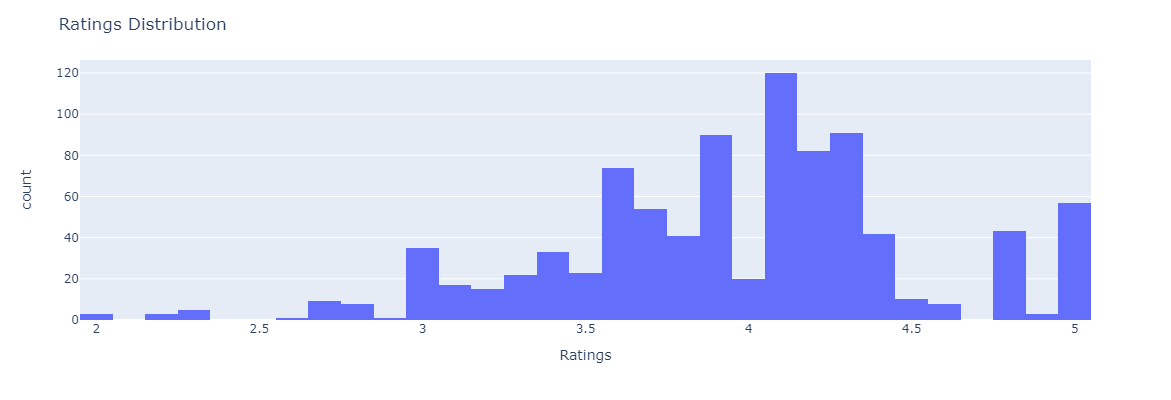

In [56]:
fig = px.histogram(data, x="Ratings")
fig.update_layout(title='Ratings Distribution', width=800, height=400)
fig.show()

### A deeper dive into features

In [57]:
def plot_histogram_with_other_column(df: pd.DataFrame, column_name: str, fraction):
    value_counts = df[column_name].value_counts()
    entries_to_plot = value_counts[value_counts/ len(df) > fraction]
    # entries_to_plot['Other'] = value_counts[value_counts/ len(df) <= fraction].sum()
    entries_to_plot = pd.DataFrame(entries_to_plot).reset_index()
    entries_to_plot.columns = [column_name, 'count']
    entries_to_plot.sort_values(by='count', inplace=True)
    
    return entries_to_plot

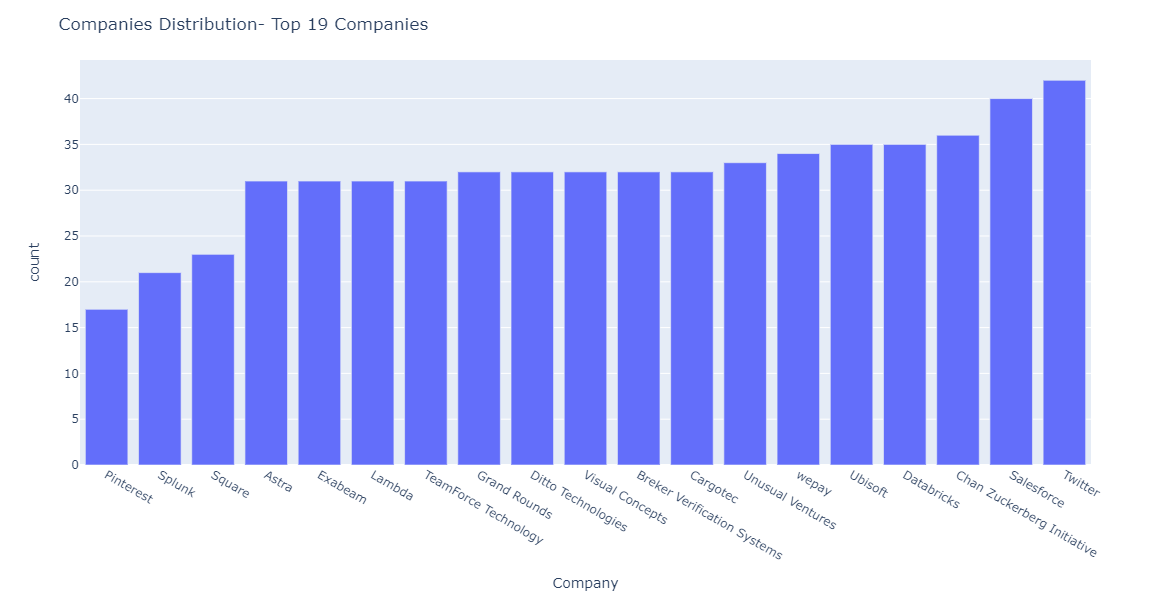

In [58]:
entries_to_plot = plot_histogram_with_other_column(data, 'Company', 0.01)

fig = px.bar(entries_to_plot, x='Company', y='count')
fig.update_layout(title='Companies Distribution- Top 19 Companies', width=1200, height=600)
fig.show()

In [59]:
def examine_features(data):
    unique_count_df = pd.DataFrame()
    features_to_count = data[['Name', 'Company', 'City', 'Day', 'Ratings']]
    for idx, col in enumerate(features_to_count.columns):
        unique_count_df.loc[idx, 'feature'] = col
        unique_count_df.loc[idx, 'count_unique']  = data[col].nunique()
    plt.figure(figsize=(10,5))
    plt.title('Unique values in each feature')
    plt.xlabel('Feature')
    plt.ylabel('Unique count')
    plt.bar(unique_count_df['feature'], unique_count_df['count_unique'], color='blueviolet')
    plt.grid(axis='y')

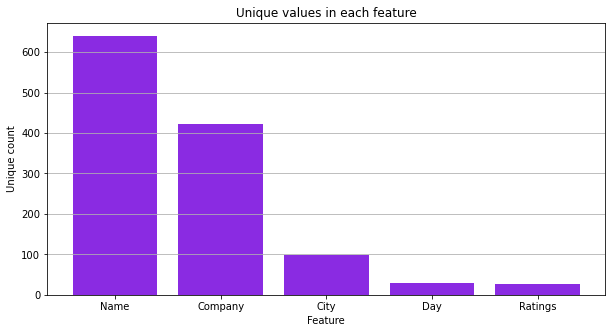

In [60]:
examine_features(data)

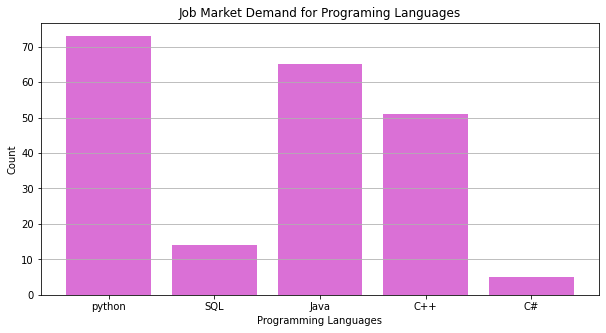

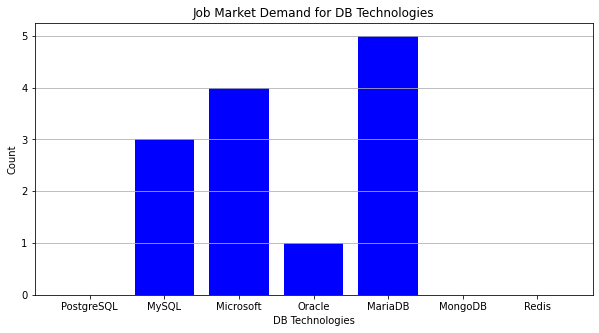

In [61]:
def examine_data(data):
    programming_languages = {'python': data['Python'].sum(), 
              'SQL': data['SQL'].sum(), 
              'Java': data['Java'].sum(),
             'C++': data['C++'].sum(),
             'C#': data['C#'].sum()
             }
    plt.figure(figsize=(10,5))
    plt.title('Job Market Demand for Programing Languages')
    plt.xlabel('Programming Languages')
    plt.ylabel('Count')
    plt.grid(axis='y')
    plt.bar(programming_languages.keys(), programming_languages.values(), color='orchid')
    
    
    db_tech = {'PostgreSQL': data['PostgreSQL'].sum(), 
          'MySQL': data['MySQL'].sum(), 
          'Microsoft': data['Microsoft'].sum(),
         'Oracle': data['Oracle'].sum(),
         'MariaDB': data['C#'].sum(),
         'MongoDB': data['MongoDB'].sum(),
         'Redis': data['MongoDB'].sum()
         }
    plt.figure(figsize=(10,5))
    plt.title('Job Market Demand for DB Technologies')
    plt.xlabel('DB Technologies')
    plt.ylabel('Count')
    plt.grid(axis='y')
    plt.bar(db_tech.keys(), db_tech.values(), color='blue')
    
    

examine_data(data)

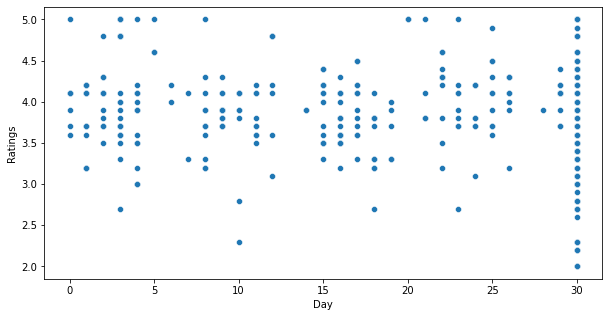

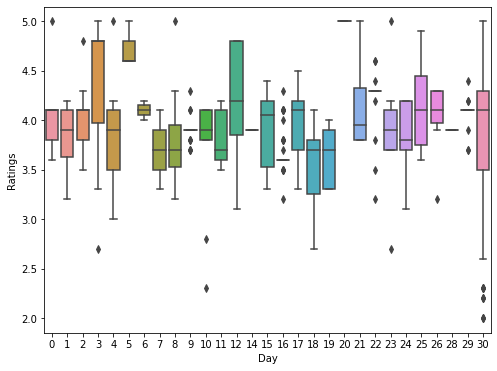

In [62]:
plt.figure(figsize=(10,5))
df = pd.DataFrame()
df['Day'] = pd.to_numeric(clean_data['Day'])
df['Ratings'] = pd.to_numeric(clean_data['Ratings'])

sns.scatterplot(data=df, x="Day", y="Ratings")

box_plot_data = pd.concat([df['Day'], df['Ratings']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Day', y="Ratings", data=box_plot_data)


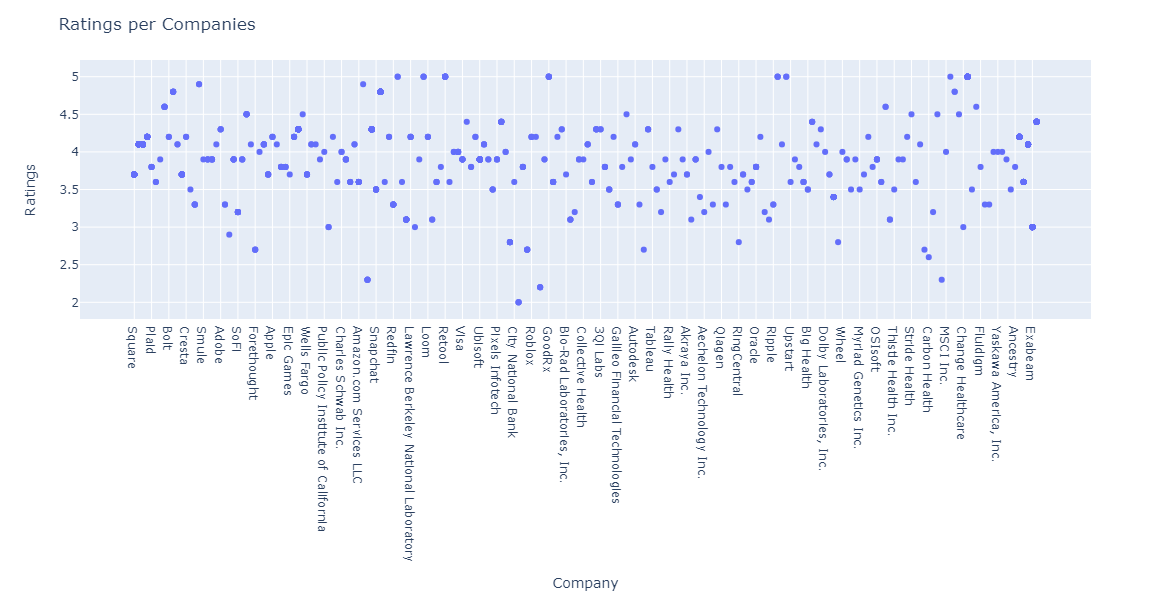

In [63]:
fig = px.scatter(clean_data, x='Company', y='Ratings')
fig.update_layout(title='Ratings per Companies', width=1200, height=600)
fig.show()

### Machine Learning Part

In [64]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np   
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

#### Split the dataset

In [102]:
X_trainset = data[~data['Ratings'].isna()]
test = data[data['Ratings'].isna()]
X = X_trainset.iloc[:, :-1]
y = X_trainset.iloc[:, -1]

X = X[['Name', 'Company', 'City', 'Day']]
X_pre_dummies = X
X_pre_dummies

,Name,Company,City,Day
0,"Software Engineer, Integrations",Square,"San Francisco, CA 94103 (South of Market area)",1
1,"Software Engineer, Backend - Tweet Services",Twitter,"San Francisco, CA 94103 (South of Market area)",2
3,Software Engineer - C++,Splunk,"San Francisco, CA",0
5,University Grad Software Engineer,Pinterest,"San Francisco, CA 94103 (South of Market area)",29
6,Software Engineer - Intern,Plaid,"San Francisco, CA",30
...,...,...,...,...
1424,"Sr. Software Engineer, Rendering",Ditto Technologies,"Oakland, CA",30
1425,Gameplay Network Engineer,Ubisoft,"San Francisco, CA 94107 (South Beach area)",9
1426,Staff Software Engineer,wepay,"Redwood City, CA (Downtown area)",30
1427,Android Engineer,Grand Rounds,"San Francisco, CA",30


In [81]:
y

0       3.7
1       4.1
3       4.1
5       4.2
6       3.8
       ... 
1424    5.0
1425    3.9
1426    4.3
1427    3.4
1428    4.4
Name: Ratings, Length: 910, dtype: float64

#### Encode categorical features

In [82]:
# Apply get dummies to each column with categorical data in X
X = pd.get_dummies(X, columns=['Name', 'Company', 'City'])
X_test = test[['Name', 'Company', 'City', 'Day']]
X_test = pd.get_dummies(X_test, columns=['Name', 'Company', 'City'])
X

,Day,Name_2021 Graduate Summer Internship Program Technology and Opera...,"Name_AMTS Software Engineer, Mulesoft",Name_Android Engineer,Name_Android Engineer (Consumer Apps) - San Francisco,Name_Android Engineer - Quip,"Name_Android Software Engineer, Adobe Spark",Name_Android developer,Name_Associate Game Designer (New Project),Name_Associate Gameplay Engineer,...,"City_San Leandro, CA 94577","City_San Mateo, CA","City_San Mateo, CA 94402 (Aragon area)","City_San Mateo, CA 94402 (Sunnybrae area)","City_San Mateo, CA 94403 (Sugerloaf area)","City_San Mateo, CA 94404","City_Sausalito, CA","City_South San Francisco, CA","City_South San Francisco, CA 94080","City_Walnut Creek, CA"
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1425,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1426,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1427,30,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
# Splitting the dataset into the Training and Validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_train

,Day,Name_2021 Graduate Summer Internship Program Technology and Opera...,"Name_AMTS Software Engineer, Mulesoft",Name_Android Engineer,Name_Android Engineer (Consumer Apps) - San Francisco,Name_Android Engineer - Quip,"Name_Android Software Engineer, Adobe Spark",Name_Android developer,Name_Associate Game Designer (New Project),Name_Associate Gameplay Engineer,...,"City_San Leandro, CA 94577","City_San Mateo, CA","City_San Mateo, CA 94402 (Aragon area)","City_San Mateo, CA 94402 (Sunnybrae area)","City_San Mateo, CA 94403 (Sugerloaf area)","City_San Mateo, CA 94404","City_Sausalito, CA","City_South San Francisco, CA","City_South San Francisco, CA 94080","City_Walnut Creek, CA"
691,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1115,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
898,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
138,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
907,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
321,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1045,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
950,29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



**The model I'm using here is the Random Forest model for regression-**

Random Forest model is one of the most accurate learning algorithms available. For many data sets, it produces a highly accurate regressor. It would also be efficient if we would like to test it on larger databases. This model also allows me to test which features are important in the regression. The disadvantages of this model, as you would see next, is that it can overfit for the dataset. Another problematic issue can be with data including categorical variables with different number of levels, random forests are biased in favor of those attributes with more levels.

#### Random Hyperparameter Grid- 

##### find the best hyperparameters for the Random Forest Regressor

In [84]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(4, 60, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [85]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

This part would take a lot of time please be patient:

In [ ]:
base_model = RandomForestRegressor(random_state = 0)

rf_random = RandomizedSearchCV(estimator = base_model, param_distributions = random_grid, 
                               n_iter = 100, cv = 5, random_state = 0)
rf_random.fit(X_train, y_train)

print(rf_random.best_params_)

In [86]:
print('Base Model')
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_valid, y_valid)

print('\nBest Estimator Performance')
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_valid, y_valid)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Base Model
Model Performance
Average Error: 0.1114 degrees.
Accuracy = 96.80%.

Best Estimator Performance
Model Performance
Average Error: 0.0868 degrees.
Accuracy = 97.46%.
Improvement of 0.68%.


#### Instantiate a random forest regressor

Hyperparameters were determined according to randomized search above

In [87]:
Model = RandomForestRegressor(n_estimators = 78, min_samples_split=15, min_samples_leaf=1, 
                               max_features='auto', max_depth=None, bootstrap=False, random_state = 0)
Model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, min_samples_split=15, n_estimators=78,
                      random_state=0)

In [88]:
y_pred = Model.predict(X_valid)

In [89]:
df_valid_vs_pred = pd.DataFrame()
df_valid_vs_pred['y_valid'] = y_valid
df_valid_vs_pred['y_pred'] = y_pred
df_valid_vs_pred['y_baseline'] = 3

df_valid_vs_pred

,y_valid,y_pred,y_baseline
431,4.3,4.300000,3
1180,4.1,4.100000,3
504,4.3,3.745540,3
1025,3.9,3.900000,3
237,4.1,4.100000,3
...,...,...,...
1417,3.6,3.600000,3
685,4.1,4.100000,3
1213,4.8,4.800000,3
3,4.1,4.100000,3


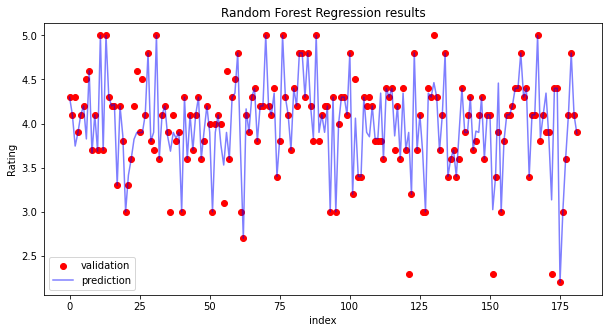

In [90]:
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(y_valid)), y_valid, color = 'red', label='validation')
plt.plot(np.arange(len(y_pred)),y_pred, color = 'blue', alpha =0.5, label='prediction')
plt.title('Random Forest Regression results')
plt.xlabel('index')
plt.ylabel('Rating')
plt.legend()

Text(-4, 0.2, 'y=0.83X+0.79')

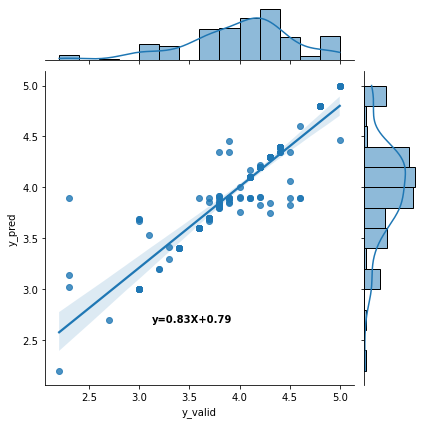

In [91]:
g = sns.jointplot(x='y_valid', y='y_pred', data = df_valid_vs_pred, kind="reg" )
from sklearn import linear_model
regr = linear_model.LinearRegression()
X = df_valid_vs_pred.y_valid.values.reshape(-1,1)
y = df_valid_vs_pred.y_pred.values.reshape(-1,1)
regr.fit(X, y)
b = round(regr.coef_[0][0],2)
a = round(regr.intercept_[0],2)
# g = sns.lmplot('x','y',df,fit_reg=True,aspect=1.5,ci=None, scatter_kws={"s": 100})
ax = plt.gca()
ax.text(-4, 0.2, f"y={a}X+{b}", transform=ax.transAxes, size='medium', color='black', weight='semibold')


In [92]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, y_pred)))

print('\nMean Absolute Error:', metrics.mean_absolute_error(y_valid, df_valid_vs_pred['y_baseline']))
print('Mean Squared Error:', metrics.mean_squared_error(y_valid,  df_valid_vs_pred['y_baseline']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid,  df_valid_vs_pred['y_baseline'])))


Mean Absolute Error: 0.08681916456324999
Mean Squared Error: 0.05349043911754769
Root Mean Squared Error: 0.23128000155125322

Mean Absolute Error: 1.0252747252747252
Mean Squared Error: 1.2826373626373624
Root Mean Squared Error: 1.1325358107527383


In [106]:
def visualize_features_importance(df):
    
    importances = Model.feature_importances_ 
    features_X_train = list(df.columns)   
    df_import_Xtrain = pd.DataFrame(list(zip(features_X_train, importances)), 
                                    columns =['features', 'importances'])    
    df_import_Xtrain['std'] = np.std([Model.feature_importances_ for tree in Model.estimators_], axis=0)   
    df_import_Xtrain = df_import_Xtrain[df_import_Xtrain['importances']>0.01]   
    df_import_Xtrain.sort_values(by='importances', inplace=True, ascending=False)    
    # Plot feature importances of the forest
    plt.figure()
    plt.title("Features importances")
    plt.bar(df_import_Xtrain['features'], df_import_Xtrain['importances'],
            color="r", yerr=df_import_Xtrain['std'], align="center")
    plt.xticks(range(len(df_import_Xtrain)), df_import_Xtrain['features'], rotation = 'vertical')   

Std is very small therefore it will not appear on graph

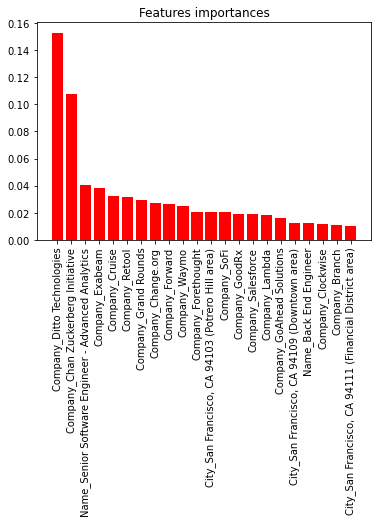

In [107]:
visualize_features_importance(X_train)

As we can see the most important feature affecting the label result is the company name (Ditto Technologies).  The model  gives a good prediction over the validation group (RMSE of 0.23). A lot of work can be done in order to improve the model, for example we can add much more data (The robot protection of the site prevented me from downloading more data), continue playing with the hyperparameters for a better result, we can revaluate the random search algorithm aand we can try more models and evaluate them.